# Group 1
### Marc Bitar, Davin Patel, Rishabh Jain, Beau Tse


## Import and Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Preprocess

##### Import Data into code

In [2]:
df_math = pd.read_csv('Maths.csv')
df_portuguese = pd.read_csv('Portuguese.csv')

In [3]:
df_math['subject'] = 'math'
df_portuguese['subject'] = 'portuguese'

In [4]:
df = pd.concat([df_math, df_portuguese])

##### Scale the data

In [5]:
df['Average_Grade'] = df[['G1', 'G2', 'G3']].mean(axis=1)

In [6]:
df.loc[(df['Average_Grade'] >= 0) & (df['Average_Grade'] < 10), 'Average_Grade'] = 0
df.loc[(df['Average_Grade'] >= 10) & (df['Average_Grade'] < 14), 'Average_Grade'] = 1
df.loc[(df['Average_Grade'] >= 14) & (df['Average_Grade'] <= 16), 'Average_Grade'] = 2
df.loc[(df['Average_Grade'] > 16) & (df['Average_Grade'] <= 20), 'Average_Grade'] = 3

### Problems

#### Predicting the Need for Educational Support

In [7]:
continuous_columns = ['age']
nominal_columns = ['school','sex' ,'address' ,'famsize' ,'Pstatus','Medu' ,'Fedu','Mjob' ,'Fjob','reason' ,'guardian','traveltime',
'studytime','famsup' ,'paid' ,'activities' ,'nursery' ,'higher' ,'internet' ,'romantic', 'subject']
ordinal_columns = ['famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

In [8]:
X = df[['age','school','sex' ,'address' ,'famsize' ,'Pstatus','Medu' ,'Fedu','Mjob' ,'Fjob','reason' ,'guardian','traveltime',
'studytime','famsup' ,'paid' ,'activities' ,'nursery' ,'higher' ,'internet' ,'romantic', 'subject',
'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']]
y = df['schoolsup']

In [9]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

##### Autogluon

In [10]:
X_preprocessed = preprocessor.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed,  y, shuffle = True, random_state = 42)

In [12]:
train_df = pd.concat([pd.DataFrame(X_train).reset_index(drop=True), pd.DataFrame(y_train).reset_index(drop=True)], axis=1)
test_df = pd.concat([pd.DataFrame(X_test).reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True)], axis=1)

In [13]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset(train_df)

/Users/marcbitar/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
from autogluon.tabular import TabularPredictor
save_path = 'any'
label = 'schoolsup' # specifies which column do we want to predict
predictor = TabularPredictor(label=label, path=save_path).fit(train_data, time_limit=600)

No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "any"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.9.6
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.2.0: Wed Nov 15 21:54:10 PST 2023; root:xnu-10002.61.3~2/RELEASE_X86_64
CPU Count:          8
Memory Avail:       2.56 GB /

In [15]:
test_data = TabularDataset(test_df)
y_test = test_data[label] # values to predict

In [16]:
test_data_nolab = test_data.drop(columns=[label])

In [17]:
predictor = TabularPredictor.load(save_path)

In [18]:
y_pred = predictor.predict(test_data_nolab)

In [19]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics={'auc'})
leaderboard = predictor.leaderboard(test_data, silent=True)
display(leaderboard, perf)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist,0.931034,0.961783,accuracy,0.018275,0.018760,0.009435,0.018275,0.018760,0.009435,1,True,2
1,CatBoost,0.923372,0.974522,accuracy,0.010296,0.006124,1.241605,0.010296,0.006124,1.241605,1,True,5
2,WeightedEnsemble_L2,0.923372,0.974522,accuracy,0.012755,0.007515,2.021947,0.002459,0.001391,0.780342,2,True,11
3,RandomForestGini,0.919540,0.961783,accuracy,0.188675,0.067623,0.665942,0.188675,0.067623,0.665942,1,True,3
4,ExtraTreesGini,0.915709,0.961783,accuracy,0.108351,0.062174,0.642564,0.108351,0.062174,0.642564,1,True,6
5,RandomForestEntr,0.915709,0.961783,accuracy,0.167635,0.064693,0.638103,0.167635,0.064693,0.638103,1,True,4
6,ExtraTreesEntr,0.911877,0.961783,accuracy,0.099414,0.064537,0.638995,0.099414,0.064537,0.638995,1,True,7
7,NeuralNetFastAI,0.900383,0.942675,accuracy,0.018011,0.010207,2.064973,0.018011,0.010207,2.064973,1,True,8
8,KNeighborsUnif,0.900383,0.891720,accuracy,0.018111,0.042343,3.545122,0.018111,0.042343,3.545122,1,True,1
9,XGBoost,0.892720,0.942675,accuracy,0.012913,0.006176,0.265359,0.012913,0.006176,0.265359,1,True,9


{'accuracy': 0.9233716475095786,
 'balanced_accuracy': 0.6702586206896552,
 'mcc': 0.5326178913459613,
 'f1': 0.5000000000000001,
 'precision': 0.9090909090909091,
 'recall': 0.3448275862068966}

#### Models

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, shuffle = True, random_state = 42)

##### Random Forest

In [21]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, criterion='gini'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__n_estimators': [400, 800, 1100],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['school',
                                                                          'sex',
                                                                          'address',
                                                                          'famsize',
                                                                          'Pstatus',
                                                                          'Medu',
                                                                          'Fedu',
                                                                          'Mjob',
                                                                          'Fjob',
                                                                          'reason',
                                                                          'guardian',
                                                                          'traveltime',
                                                                          'studytime',
                                                                          'famsup...
                                                                          'freetime',
                                                                          'goout',
                                                                          'Dalc',
                                                                          'Walc',
                                                                          'health']),
                                                                        ('continuous',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 5, 10],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [400, 800, 1100]},
             scoring='roc_auc')

In [22]:
import pandas as pd
import pandas as pd
from sklearn.metrics import roc_auc_score
# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Get the feature importances
# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Get the feature importances
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Print the AUC score and best parameters
print("AUC Score:", auc_score)
print("Best Parameters:", grid_search.best_params_)


# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

AUC Score: 0.8478002378121284
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 800}


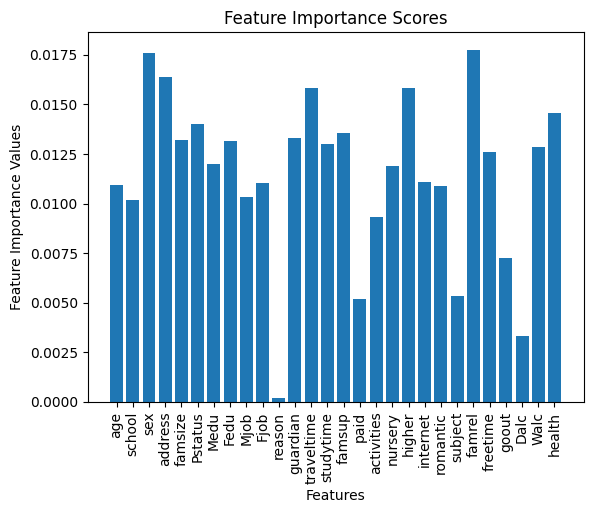

In [23]:
total_cols = continuous_columns + nominal_columns + ordinal_columns
best_model = grid_search.best_estimator_
best_coefficients = best_model.named_steps['classifier'].feature_importances_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}

plt.bar(result_dict.keys(), result_dict.values())
plt.xlabel('Features')
plt.ylabel('Feature Importance Values')
plt.title('Feature Importance Scores')
plt.xticks(rotation=90)
plt.show()


#### Logistic Regression Model

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__C': [0.001, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['school',
                                                                          'sex',
                                                                          'address',
                                                                          'famsize',
                                                                          'Pstatus',
                                                                          'Medu',
                                                                          'Fedu',
                                                                          'Mjob',
                                                                          'Fjob',
                                                                          'reason',
                                                                          'guardian',
                                                                          'traveltime',
                                                                          'studytime',
                                                                          'famsup...
                                                                                         ('encoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['famrel',
                                                                          'freetime',
                                                                          'goout',
                                                                          'Dalc',
                                                                          'Walc',
                                                                          'health']),
                                                                        ('continuous',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age'])])),
                                       ('classifier',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': [0.001, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [25]:
# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Get the optimal parameters
optimal_params = grid_search.best_params_

# Output the results
print("AUC Score:", auc_score)
print("Optimal Parameters:", optimal_params)


AUC Score: 0.7079369797859691
Optimal Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2'}


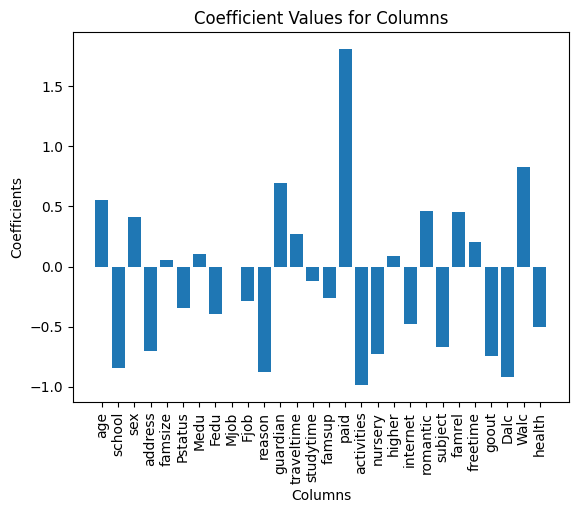

In [27]:
best_logistic_regression = grid_search.best_estimator_['classifier']
best_coefficients = best_logistic_regression.coef_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients[0])}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients[0])}

plt.bar(result_dict.keys(), result_dict.values())
plt.xlabel('Columns')
plt.ylabel('Coefficients')
plt.title('Coefficient Values for Columns')
plt.xticks(rotation=90)
plt.show()


##### Which feature are most influential on alcohol consumptions, comparison between weekday and weekend

###### Dalc ~ choosen because we are examining school factors on alcohol consumption which transpires on week days

In [28]:
continuous_columns = ['age', 'absences', 'G1', 'G2', 'G3', 'Average_Grade']
nominal_columns = ['school','sex' ,'address' ,'famsize' ,'Pstatus','Medu' ,'Fedu','Mjob' ,'Fjob','reason' ,'guardian','traveltime',
'studytime','failures','schoolsup' ,'famsup' ,'paid' ,'activities' ,'nursery' ,'higher' ,'internet' ,'romantic', 'subject']
ordinal_columns = ['famrel', 'freetime', 'goout', 'health']


total_cols = nominal_columns  + ordinal_columns + continuous_columns

In [29]:
df['avg_alcohol'] = (df['Dalc'] + df['Walc']) / 2


In [30]:
X = df[total_cols]
y = df['Dalc']

In [31]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

In [201]:
X_preprocessed = preprocessor.fit_transform(X)

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, shuffle = True, random_state = 42)

In [203]:
train_df = pd.concat([pd.DataFrame(X_train).reset_index(drop=True), pd.DataFrame(y_train).reset_index(drop=True)], axis=1)
test_df = pd.concat([pd.DataFrame(X_test).reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True)], axis=1)

In [204]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset(train_df)

In [205]:
from autogluon.tabular import TabularPredictor
label = 'Dalc' # specifies which column do we want to predict
predictor = TabularPredictor(label=label, path='any').fit(train_data, time_limit=600)


No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "any"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.9.6
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.2.0: Wed Nov 15 21:54:10 PST 2023; root:xnu-10002.61.3~2/RELEASE_X86_64
CPU Count:          8
Memory Avail:       2.13 GB /

In [206]:
test_data = TabularDataset(test_df)
y_test = test_data[label] # values to predict

In [207]:
test_data_nolab = test_data.drop(columns=[label])

In [208]:
predictor = TabularPredictor.load(save_path)

In [209]:
y_pred = predictor.predict(test_data_nolab)

In [210]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics={'auc'})
leaderboard = predictor.leaderboard(test_data, silent=True)
display(leaderboard, perf)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr,0.812261,0.783439,accuracy,0.430516,0.153173,1.314433,0.430516,0.153173,1.314433,1,True,8
1,CatBoost,0.808429,0.802548,accuracy,0.032859,0.007927,14.321364,0.032859,0.007927,14.321364,1,True,6
2,WeightedEnsemble_L2,0.808429,0.808917,accuracy,0.470513,0.162618,17.183928,0.007138,0.001518,1.548131,2,True,11
3,ExtraTreesGini,0.800766,0.777070,accuracy,0.480186,0.148928,1.240775,0.480186,0.148928,1.240775,1,True,7
4,RandomForestEntr,0.789272,0.783439,accuracy,0.383753,0.175231,1.406624,0.383753,0.175231,1.406624,1,True,5
5,RandomForestGini,0.777778,0.764331,accuracy,0.433380,0.159424,1.369036,0.433380,0.159424,1.369036,1,True,4
6,XGBoost,0.766284,0.770701,accuracy,0.166341,0.013552,2.610213,0.166341,0.013552,2.610213,1,True,9
7,NeuralNetFastAI,0.758621,0.764331,accuracy,0.056061,0.023890,4.374499,0.056061,0.023890,4.374499,1,True,3
8,KNeighborsUnif,0.708812,0.662420,accuracy,0.027888,0.034053,0.024374,0.027888,0.034053,0.024374,1,True,1
9,NeuralNetTorch,0.674330,0.713376,accuracy,0.041817,0.019781,4.872855,0.041817,0.019781,4.872855,1,True,10


{'accuracy': 0.8084291187739464,
 'balanced_accuracy': 0.4569445650600666,
 'mcc': 0.5057436205788433}

### Random Forest Entropy

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, shuffle = True, random_state = 42)

In [33]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns)
    ],
    remainder='drop'
)

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, criterion='gini'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__n_estimators': [400, 800, 1100],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

In [35]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score_ovo = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovo')

# Using the One-vs-Rest strategy
auc_score_ovr = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')

# Print the AUC scores
print("AUC Score (One-vs-One):", auc_score_ovo)
print("AUC Score (One-vs-Rest):", auc_score_ovr)

AUC Score (One-vs-One): 0.8303566965793407
AUC Score (One-vs-Rest): 0.866119914324044


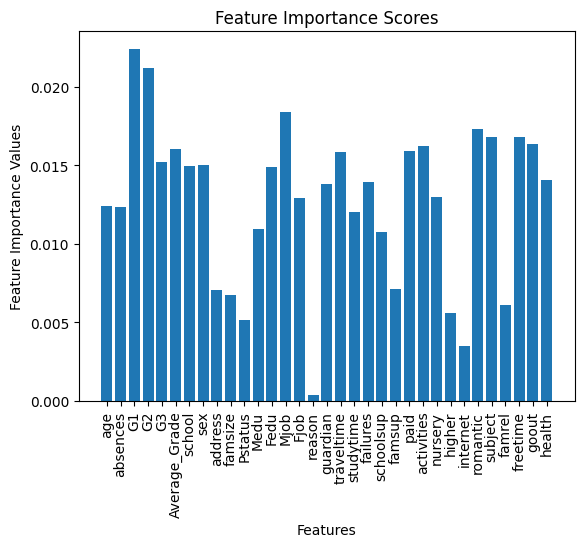

In [36]:
total_cols = continuous_columns + nominal_columns + ordinal_columns
best_model = grid_search.best_estimator_
best_coefficients = best_model.named_steps['classifier'].feature_importances_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}

plt.bar(result_dict.keys(), result_dict.values())
plt.xlabel('Features')
plt.ylabel('Feature Importance Values')
plt.title('Feature Importance Scores')
plt.xticks(rotation=90)
plt.show()

### Logistic Regression

In [37]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

In [38]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__C': [0.001, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}



In [39]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score_ovo = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovo')

# Using the One-vs-Rest strategy
auc_score_ovr = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')

# Print the AUC scores
print("AUC Score (One-vs-One):", auc_score_ovo)
print("AUC Score (One-vs-Rest):", auc_score_ovr)

AUC Score (One-vs-One): 0.6197017537511458
AUC Score (One-vs-Rest): 0.704061818622908


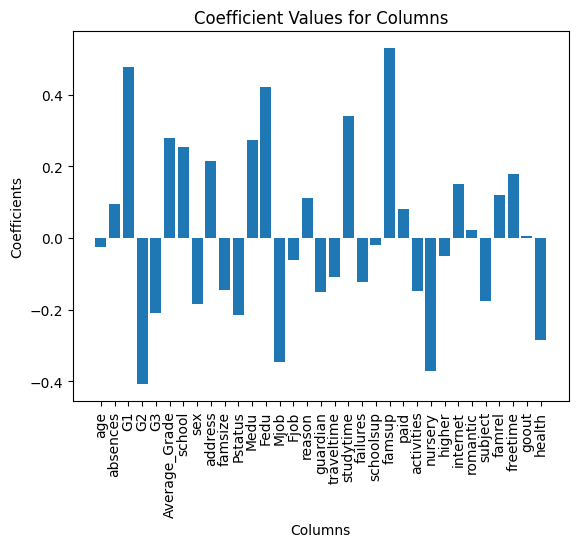

In [40]:
best_logistic_regression = grid_search.best_estimator_['classifier']
best_coefficients = best_logistic_regression.coef_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients[0])}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients[0])}

plt.bar(result_dict.keys(), result_dict.values())
plt.xlabel('Columns')
plt.ylabel('Coefficients')
plt.title('Coefficient Values for Columns')
plt.xticks(rotation=90)
plt.show()


##### Walc

In [41]:
continuous_columns = ['age', 'absences', 'G1', 'G2', 'G3', 'Average_Grade']
nominal_columns = ['school','sex' ,'address' ,'famsize' ,'Pstatus','Medu' ,'Fedu','Mjob' ,'Fjob','reason' ,'guardian','traveltime',
'studytime','failures','schoolsup' ,'famsup' ,'paid' ,'activities' ,'nursery' ,'higher' ,'internet' ,'romantic', 'subject']
ordinal_columns = ['famrel', 'freetime', 'goout', 'health']


total_cols = nominal_columns  + ordinal_columns + continuous_columns

In [42]:
df['avg_alcohol'] = (df['Dalc'] + df['Walc']) / 2


In [43]:
X = df[total_cols]
y = df['Walc']

In [44]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

In [214]:
X_preprocessed = preprocessor.fit_transform(X)

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, shuffle = True, random_state = 42)

In [216]:
train_df = pd.concat([pd.DataFrame(X_train).reset_index(drop=True), pd.DataFrame(y_train).reset_index(drop=True)], axis=1)
test_df = pd.concat([pd.DataFrame(X_test).reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True)], axis=1)

In [217]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset(train_df)

In [219]:
from autogluon.tabular import TabularPredictor
label = 'Walc' # specifies which column do we want to predict
predictor = TabularPredictor(label=label, path='any').fit(train_data, time_limit=600)


No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "any"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.9.6
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.2.0: Wed Nov 15 21:54:10 PST 2023; root:xnu-10002.61.3~2/RELEASE_X86_64
CPU Count:          8
Memory Avail:       2.00 GB /

In [220]:
test_data = TabularDataset(test_df)
y_test = test_data[label] # values to predict

In [221]:
test_data_nolab = test_data.drop(columns=[label])

In [222]:
predictor = TabularPredictor.load(save_path)

In [223]:
y_pred = predictor.predict(test_data_nolab)

In [224]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics={'auc'})
leaderboard = predictor.leaderboard(test_data, silent=True)
display(leaderboard, perf)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr,0.685824,0.592357,accuracy,0.223805,0.126704,1.534952,0.223805,0.126704,1.534952,1,True,8
1,ExtraTreesGini,0.674330,0.579618,accuracy,0.221262,0.196713,1.654521,0.221262,0.196713,1.654521,1,True,7
2,RandomForestEntr,0.670498,0.592357,accuracy,0.251301,0.176686,1.823488,0.251301,0.176686,1.823488,1,True,5
3,RandomForestGini,0.655172,0.585987,accuracy,0.285402,0.347947,1.722466,0.285402,0.347947,1.722466,1,True,4
4,WeightedEnsemble_L2,0.643678,0.662420,accuracy,0.370027,0.243628,5.195332,0.006694,0.002308,1.450795,2,True,11
5,XGBoost,0.628352,0.643312,accuracy,0.105507,0.013504,2.070621,0.105507,0.013504,2.070621,1,True,9
6,NeuralNetFastAI,0.613027,0.605096,accuracy,0.062958,0.020599,4.081194,0.062958,0.020599,4.081194,1,True,3
7,CatBoost,0.601533,0.636943,accuracy,0.020605,0.007704,5.655946,0.020605,0.007704,5.655946,1,True,6
8,KNeighborsUnif,0.398467,0.407643,accuracy,0.036564,0.031103,0.019395,0.036564,0.031103,0.019395,1,True,1
9,KNeighborsDist,0.390805,0.394904,accuracy,0.028817,0.022489,0.025296,0.028817,0.022489,0.025296,1,True,2


{'accuracy': 0.6436781609195402,
 'balanced_accuracy': 0.6033870750632873,
 'mcc': 0.4997947742894954}

### Random Forest Entropy

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, shuffle = True, random_state = 42)

In [46]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns)
    ],
    remainder='drop'
)

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, criterion='gini'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__n_estimators': [400, 800, 1100],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

In [48]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score_ovo = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovo')

# Using the One-vs-Rest strategy
auc_score_ovr = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')

# Print the AUC scores
print("AUC Score (One-vs-One):", auc_score_ovo)
print("AUC Score (One-vs-Rest):", auc_score_ovr)


AUC Score (One-vs-One): 0.9027421948889953
AUC Score (One-vs-Rest): 0.9044902450758974


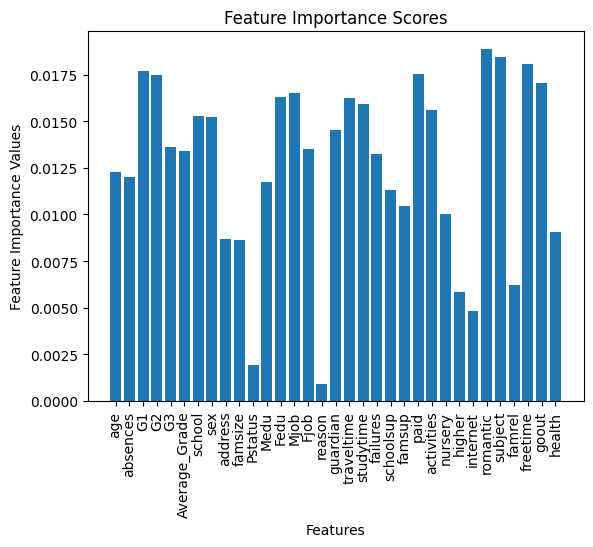

In [49]:
total_cols = continuous_columns + nominal_columns + ordinal_columns
best_model = grid_search.best_estimator_
best_coefficients = best_model.named_steps['classifier'].feature_importances_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}

plt.bar(result_dict.keys(), result_dict.values())
plt.xlabel('Features')
plt.ylabel('Feature Importance Values')
plt.title('Feature Importance Scores')
plt.xticks(rotation=90)
plt.show()

### Logistic Regression

In [50]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

In [51]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Define the parameter grid for grid search
param_grid = {
    'classifier__C': [0.001, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

In [52]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
auc_score_ovo = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovo')

# Using the One-vs-Rest strategy
auc_score_ovr = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')

# Print the AUC scores
print("AUC Score (One-vs-One):", auc_score_ovo)
print("AUC Score (One-vs-Rest):", auc_score_ovr)

AUC Score (One-vs-One): 0.6733524511532754
AUC Score (One-vs-Rest): 0.6852489481917979


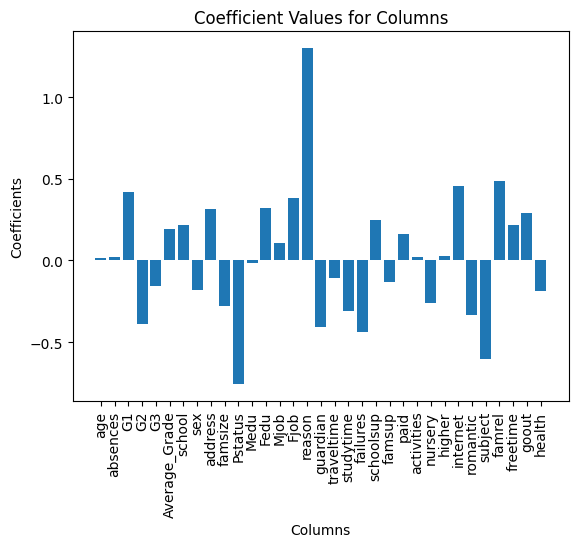

In [53]:
best_logistic_regression = grid_search.best_estimator_['classifier']
best_coefficients = best_logistic_regression.coef_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients[0])}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients[0])}

plt.bar(result_dict.keys(), result_dict.values())
plt.xlabel('Columns')
plt.ylabel('Coefficients')
plt.title('Coefficient Values for Columns')
plt.xticks(rotation=90)
plt.show()


#### Can we predict if kids are interested in higher education and target these students

In [54]:
continuous_columns = ['age', 'absences', 'G1', 'G2', 'G3']
nominal_columns = ['school','sex' ,'address' ,'Medu' ,'Fedu','Mjob' ,'Fjob','reason' ,'guardian','traveltime',
                   'studytime','failures','schoolsup' ,'paid' ,'activities' ,'nursery','internet' ,
                   'romantic', 'subject','famsize' , 'Pstatus']
ordinal_columns = ['freetime', 'goout', 'Dalc', 'Walc', 'health']

In [55]:
total_cols = nominal_columns + continuous_columns + ordinal_columns

In [56]:
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
        ]), nominal_columns),
        ('ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), ordinal_columns),
        ('continuous', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), continuous_columns),
    ],
    remainder='drop'
)

In [57]:
X = df[total_cols]
y = df['higher']

In [60]:
X_preprocessed = preprocessor.fit_transform(X)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, shuffle = True, random_state = 42)

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Define the logistic regression model
logreg = LogisticRegression(solver = 'saga', max_iter=10000, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(logreg, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
log_reg_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Get the best hyperparameters
best_params = grid_search.best_params_

# Output the results
print("Best AUC Score:", log_reg_auc_score)
print("Best Hyperparameters:", best_params)


Best AUC Score: 0.8780905287181437
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}


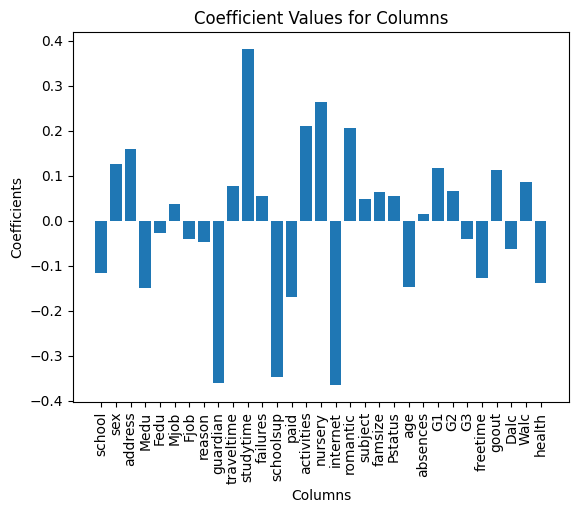

In [63]:
best_logistic_regression = grid_search.best_estimator_
best_coefficients = best_logistic_regression.coef_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients[0])}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients[0])}

plt.bar(result_dict.keys(), result_dict.values())
plt.xlabel('Columns')
plt.ylabel('Coefficients')
plt.title('Coefficient Values for Columns')
plt.xticks(rotation=90)
plt.show()


In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define the decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Define the parameter grid for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(dt_classifier, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
dec_tree_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Get the best hyperparameters
best_params = grid_search.best_params_

# Output the results
print("Best AUC Score:", dec_tree_auc_score)
print("Best Hyperparameters:", best_params)


Best AUC Score: 0.7391593761886648
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create a random forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
rand_for_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Print the best parameters and AUC score
print("Best Parameters:", grid_search.best_params_)
print("AUC Score:", rand_for_auc_score)


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
AUC Score: 0.9121338912133892


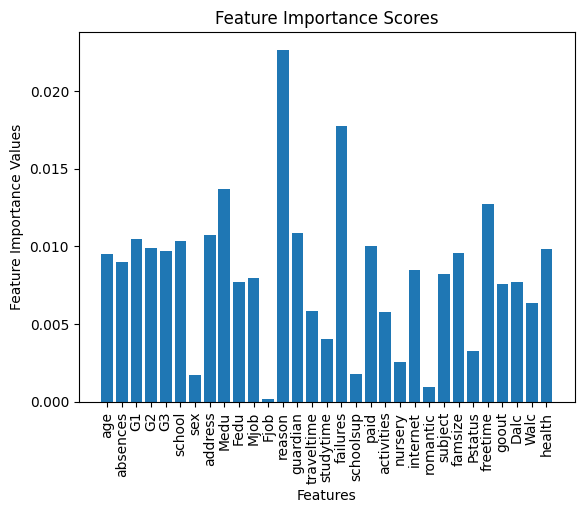

In [67]:
total_cols = continuous_columns + nominal_columns + ordinal_columns
best_model = grid_search.best_estimator_
best_coefficients = best_model.feature_importances_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}

plt.bar(result_dict.keys(), result_dict.values())
plt.xlabel('Features')
plt.ylabel('Feature Importance Values')
plt.title('Feature Importance Scores')
plt.xticks(rotation=90)
plt.show()


In [68]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Create a gradient boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gb_classifier, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
grad_boost_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Print the best parameters and AUC score
print("Best Parameters:", grid_search.best_params_)
print("AUC Score:", grad_boost_auc_score)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
AUC Score: 0.8923545074172688


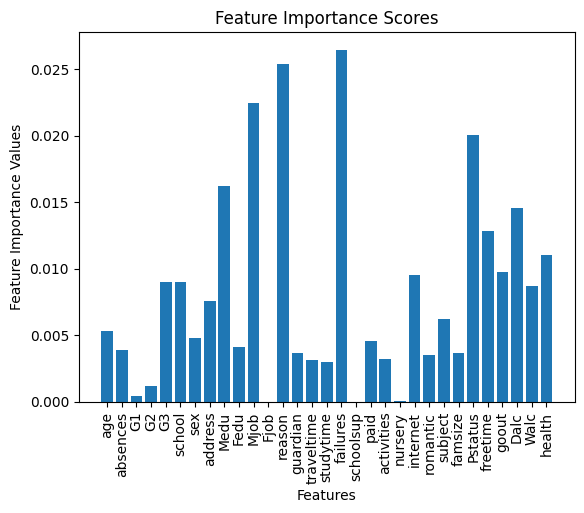

In [69]:
total_cols = continuous_columns + nominal_columns + ordinal_columns
best_model = grid_search.best_estimator_
best_coefficients = best_model.feature_importances_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}

plt.bar(result_dict.keys(), result_dict.values())
plt.xlabel('Features')
plt.ylabel('Feature Importance Values')
plt.title('Feature Importance Scores')
plt.xticks(rotation=90)
plt.show()


In [70]:
y_new = y.map({'yes': 1, 'no': 0})
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_new, shuffle = True, random_state = 42)

In [71]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

# Create an XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_classifier, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its AUC score
best_model = grid_search.best_estimator_
xgb_auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Print the best parameters and AUC score
print("Best Parameters:", grid_search.best_params_)
print("AUC Score:", xgb_auc_score)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
AUC Score: 0.9252567516165843


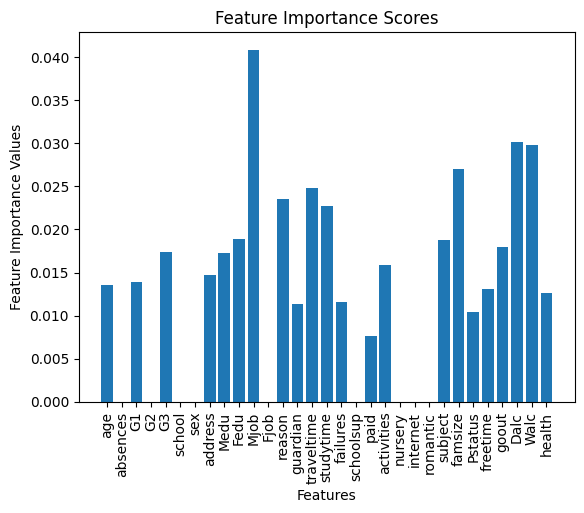

In [72]:
total_cols = continuous_columns + nominal_columns + ordinal_columns
best_model = grid_search.best_estimator_
best_coefficients = best_model.feature_importances_
result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}
import matplotlib.pyplot as plt

result_dict = {col: coef for col, coef in zip(total_cols, best_coefficients)}

plt.bar(result_dict.keys(), result_dict.values())
plt.xlabel('Features')
plt.ylabel('Feature Importance Values')
plt.title('Feature Importance Scores')
plt.xticks(rotation=90)
plt.show()


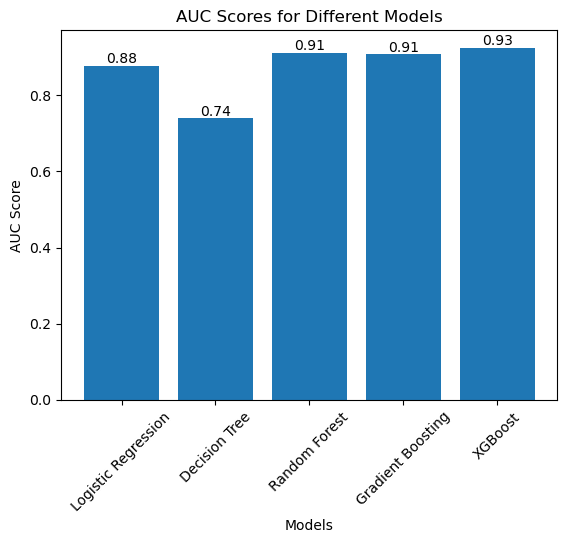

0.8780905287181437 0.7391593761886648 0.9121338912133892 0.9077596044123241 0.9252567516165843


In [30]:
import matplotlib.pyplot as plt

# Define the scores
scores = [log_reg_auc_score, dec_tree_auc_score, rand_for_auc_score, grad_boost_auc_score, xgb_auc_score]

# Define the labels
labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost']

# Create the bar chart
plt.bar(labels, scores)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Models')

for i, score in enumerate(scores):
    plt.text(i, score, str(round(score, 2)), ha='center', va='bottom')

plt.xticks(rotation=45)

# Display the chart
plt.show()
print(log_reg_auc_score, dec_tree_auc_score, rand_for_auc_score, grad_boost_auc_score, xgb_auc_score)

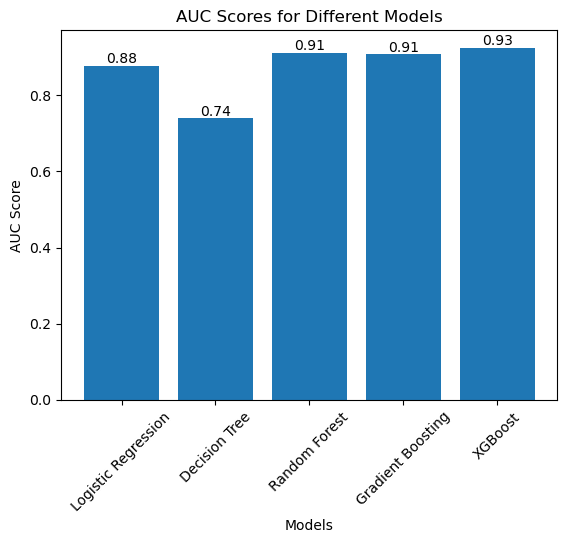

In [31]:
# Create the bar chart
plt.bar(labels, scores)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.title('AUC Scores for Different Models')

# Display the score at the top of each bar
for i, score in enumerate(scores):
    plt.text(i, score, str(round(score, 2)), ha='center', va='bottom')

plt.xticks(rotation=45)

# Display the chart
plt.show()


In [ ]:
coefficients = lr_classifier.coef_
feature_names = preprocessor.transformers_[0][1]['encoder'].get_feature_names_out(input_features=nominal_columns)
feature_names = feature_names.tolist() + ordinal_columns
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients[0]})
print(coefficients_df)


In [94]:
train_df = pd.concat([pd.DataFrame(X_train).reset_index(drop=True), pd.DataFrame(y_train).reset_index(drop=True)], axis=1)
test_df = pd.concat([pd.DataFrame(X_test).reset_index(drop=True), pd.DataFrame(y_test).reset_index(drop=True)], axis=1)

In [95]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset(train_df)

In [96]:
from autogluon.tabular import TabularPredictor
save_path = 'any'
label = 'higher' # specifies which column do we want to predict
predictor = TabularPredictor(label=label, path='any').fit(train_data, time_limit=600)


No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "any"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.9.6
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.2.0: Wed Nov 15 21:54:10 PST 2023; root:xnu-10002.61.3~2/RELEASE_X86_64
CPU Count:          8
Memory Avail:       2.01 GB /

In [97]:
test_data = TabularDataset(test_df)
y_test = test_data[label] # values to predict

In [98]:
test_data_nolab = test_data.drop(columns=[label])

In [99]:
predictor = TabularPredictor.load(save_path)

In [100]:
y_pred = predictor.predict(test_data_nolab)

In [101]:
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics={'auc'})
leaderboard = predictor.leaderboard(test_data, silent=True)
display(leaderboard, perf)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.942529,0.955414,accuracy,0.107627,0.068066,7.207935,0.010283,0.005737,1.526713,2,True,11
1,CatBoost,0.931034,0.942675,accuracy,0.020216,0.006819,1.576435,0.020216,0.006819,1.576435,1,True,5
2,ExtraTreesGini,0.927203,0.917197,accuracy,0.294106,0.136248,2.294068,0.294106,0.136248,2.294068,1,True,6
3,RandomForestGini,0.923372,0.923567,accuracy,0.299551,0.227442,2.289746,0.299551,0.227442,2.289746,1,True,3
4,KNeighborsUnif,0.919540,0.929936,accuracy,0.029448,0.040666,0.027972,0.029448,0.040666,0.027972,1,True,1
5,KNeighborsDist,0.919540,0.929936,accuracy,0.038005,0.032452,0.041682,0.038005,0.032452,0.041682,1,True,2
6,ExtraTreesEntr,0.919540,0.917197,accuracy,0.244180,0.128540,1.376309,0.244180,0.128540,1.376309,1,True,7
7,RandomForestEntr,0.919540,0.923567,accuracy,0.342386,0.129482,2.037728,0.342386,0.129482,2.037728,1,True,4
8,XGBoost,0.911877,0.942675,accuracy,0.029388,0.009746,0.827800,0.029388,0.009746,0.827800,1,True,9
9,NeuralNetTorch,0.908046,0.936306,accuracy,0.057433,0.018707,4.896834,0.057433,0.018707,4.896834,1,True,10


{'accuracy': 0.9425287356321839,
 'balanced_accuracy': 0.6797261316089769,
 'mcc': 0.5473057214040686,
 'f1': 0.969450101832994,
 'precision': 0.9444444444444444,
 'recall': 0.99581589958159}